In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

In [2]:
from tqdm.auto import tqdm
import torch
import torch.nn as nn
from data.dataset import GraphDataset, DataAugmentationLevel, DialogNode, NodeType
from typing import List, Tuple

/fs/scratch/users/vaethdk/adviser_reisekosten/.env/lib64/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
DEVICE = 'cuda:0'

In [4]:
from transformers import AutoTokenizer, AutoModelForCausalLM, set_seed
from auto_gptq import AutoGPTQForCausalLM, BaseQuantizeConfig

In [5]:
torch.cuda.device_count()

1

In [6]:
model_name_or_path = "TheBloke/upstage-llama-30b-instruct-2048-GPTQ"
model_basename = "gptq_model-4bit--1g"

use_triton = False

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path,
                                          use_fast=True,
                                          cache_dir="/mount/arbeitsdaten/asr-2/vaethdk/resources/weights/",)
model = AutoGPTQForCausalLM.from_quantized("/mount/arbeitsdaten/asr-2/vaethdk/resources/weights/TheBloke--upstage-llama-30b-instruct-2048-GPTQ",
        # model_basename=model_basename,
        # revision="gptq-4bit-32g-actorder_True",
        use_safetensors=True,
        trust_remote_code=False,
        device="cuda:0",
        use_triton=use_triton,
        quantize_config=None)

CUDA extension not installed.
The safetensors archive passed at /mount/arbeitsdaten/asr-2/vaethdk/resources/weights/TheBloke--upstage-llama-30b-instruct-2048-GPTQ/gptq_model-4bit-32g.safetensors does not contain metadata. Make sure to save your model with the `save_pretrained` method. Defaulting to 'pt' metadata.


OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 23.70 GiB total capacity; 22.56 GiB already allocated; 4.69 MiB free; 22.92 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [13]:
def generate_prompt(system: str, user: str, questions: List[str]) -> Tuple[str, List[Tuple[int, int]]]:
    """ Returns:
        Generated prompt,
        List of start/end index of each question within the tokenized prompt,
    """
    incremental_prompt = f"""
### System:
{system}

### User:
{user}

### Assistant:
"""
    token_ranges = []
    for i, question in enumerate(questions):
        incremental_prompt += f"{i+1}. "
        question_start_idx = tokenizer(incremental_prompt, return_tensors='pt').input_ids.size(-1) - 1
        incremental_prompt += question
        question_end_idx = tokenizer(incremental_prompt, return_tensors='pt').input_ids.size(-1)
        token_ranges.append((question_start_idx, question_end_idx))
        incremental_prompt += "\n"
    return incremental_prompt, token_ranges


In [14]:
system = """You are a helpful assistant creating a list of FAQ-style questions from given facts.
Only generate questions that can be answered by the given facts, without any external knowledge.
Remove some information, especially nouns and named entities, between generated questions.
Use casual language.
Order the generated paraphrases in a numbered list."""

def user(answer_text: str, num_paraphrases: int) -> str:
    return f'Generate {num_paraphrases} FAQ-style questions from the fact: "{answer_text}"'

In [15]:
def calculate_token_probablities(node: DialogNode) -> Tuple[List[torch.FloatTensor], List[torch.LongTensor]]:
    """ 
    Returns 
        A list of token probabilities (one tensor per question)
        A list of token indices
    """
    # generate prompt
    prompt, token_ranges = generate_prompt(system=system, user=user(answer_text=node.text, num_paraphrases=len(node.questions)), questions=[q.text for q in node.questions])
    with torch.no_grad():
        # forward prompt
        inputs = tokenizer(prompt, return_tensors='pt').input_ids.to(DEVICE)
        logits = model(input_ids=inputs, labels=inputs).logits.squeeze(0) # tokens x vocabulary
        # get probabilities from logits
        probs = logits.softmax(-1).to('cpu') # tokens
        # extract token probabilities for questions only
        question_probs = [probs[start:end] for start, end in token_ranges]
        token_indices = [inputs[start:end].to('cpu') for start, end in token_ranges]
    return question_probs, token_indices


In [16]:
human_data = GraphDataset('resources/en/train_graph.json', 'resources/en/train_answers.json', False, augmentation=DataAugmentationLevel.NONE)
question_probs = {}
for node in tqdm(human_data.nodes_by_type[NodeType.INFO]):
    if len(node.questions) > 0:
        question_probs, token_indices = calculate_token_probablities(node)
        question_probs[node.key] = {"p": question_probs, "tokens": token_indices}
torch.save(question_probs, "human_question_probs.pt")

- not using synonyms
===== Dataset Statistics =====
- files:  resources/en/train_graph.json resources/en/train_answers.json
- synonyms: False
- depth: 20  - degree: 13
- answers: 73
- questions: 279
- loaded original data: True
- loaded generated data: False


  0%|          | 0/80 [00:00<?, ?it/s]


RuntimeError: "addmm_impl_cpu_" not implemented for 'Half'

In [99]:
generated_data = GraphDataset('resources/en/train_graph.json', 'resources/en/train_answers.json', False, augmentation=DataAugmentationLevel.ARTIFICIAL_ONLY)
question_probs = {}
for node in tqdm(generated_data.nodes_by_type[NodeType.INFO]):
    if len(node.questions) > 0:
        question_probs[node.key] = calculate_token_probablities(node)
torch.save(question_probs, "generated_question_probs.pt")

- Loading questions from  resources/en/generated/train_questions.json
- not using synonyms
===== Dataset Statistics =====
- files:  resources/en/train_graph.json resources/en/train_answers.json
- synonyms: False
- depth: 20  - degree: 13
- answers: 73
- questions: 1012
- loaded original data: False
- loaded generated data: True


100%|██████████| 80/80 [02:17<00:00,  1.72s/it]


In [12]:
# Calculate pairwise simiarity between questions within one node 
# - for each dataset
# - compare how "diverse" the questions are

In [27]:
# Calculate perplexity of human data 
human_probs = torch.load('human_question_probs.pt', map_location=lambda storage, loc: storage)
human_perplexities = []
for node_key in human_probs:
    question_probs = human_probs[node_key] # list with probabilities per question
    for p_question in question_probs:
        print(p_question.size())
        ppl = torch.exp(-(1./p_question.size(0)) * torch.log(p_question).sum(-1))
        human_perplexities.append(ppl)
        break
    break
human_perplexities = torch.cat(human_perplexities).tolist()

# Calculate perplexity of generated data
# - compare distributions

# Also, compare lengths

torch.Size([16, 32000])


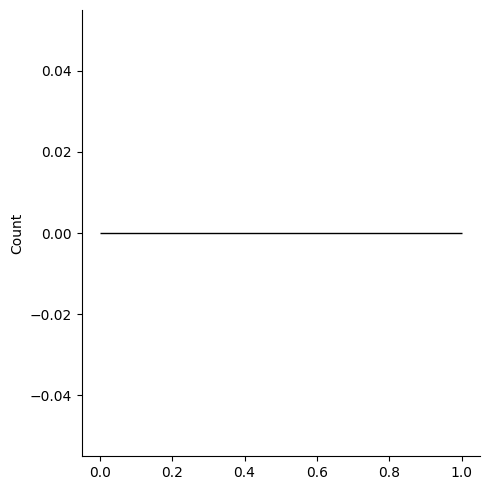

In [17]:
import seaborn as sns
sns.displot(human_perplexities)

In [18]:
human_perplexities

[inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf